In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Project/data1.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
def prepare_datasets(test_size):

    # load data
    X, y = load_data(DATA_PATH)

    # create train and test split (no validation set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_test, y_train, y_test


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization


# CNN|

In [ ]:
def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [ ]:
def predict(model, X, y):


    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


Calling the model  

In [ ]:
# get train and test splits
X_train, X_test, y_train, y_test = prepare_datasets(0.2)  # 80% training, 20% test

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                        

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 15s 52ms/step - loss: 2.2414 - accuracy: 0.2606
Epoch 2/100
248/248 [==============================] - 14s 57ms/step - loss: 1.7398 - accuracy: 0.3911
Epoch 3/100
248/248 [==============================] - 14s 57ms/step - loss: 1.5834 - accuracy: 0.4387
Epoch 4/100
248/248 [==============================] - 14s 57ms/step - loss: 1.4722 - accuracy: 0.4785
Epoch 5/100
248/248 [==============================] - 14s 57ms/step - loss: 1.3759 - accuracy: 0.5104
Epoch 6/100
248/248 [==============================] - 14s 57ms/step - loss: 1.3167 - accuracy: 0.5316
Epoch 7/100
248/248 [==============================] - 14s 57ms/step - loss: 1.2556 - accuracy: 0.5542
Epoch 8/100
248/248 [==============================] - 13s 53ms/step - loss: 1.2179 - accuracy: 0.5692
Epoch 9/100
248/248 [==============================] - 13s 53ms/step - loss: 1.1686 - accuracy: 0.5897
Epoch 10/100
248/248 [==============================] - 15s 59ms/step - l

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 0.8309 - accuracy: 0.7545 - 304ms/epoch - 5ms/step

Test accuracy: 0.7545454502105713


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

62/62 [==============================] - 0s 2ms/step


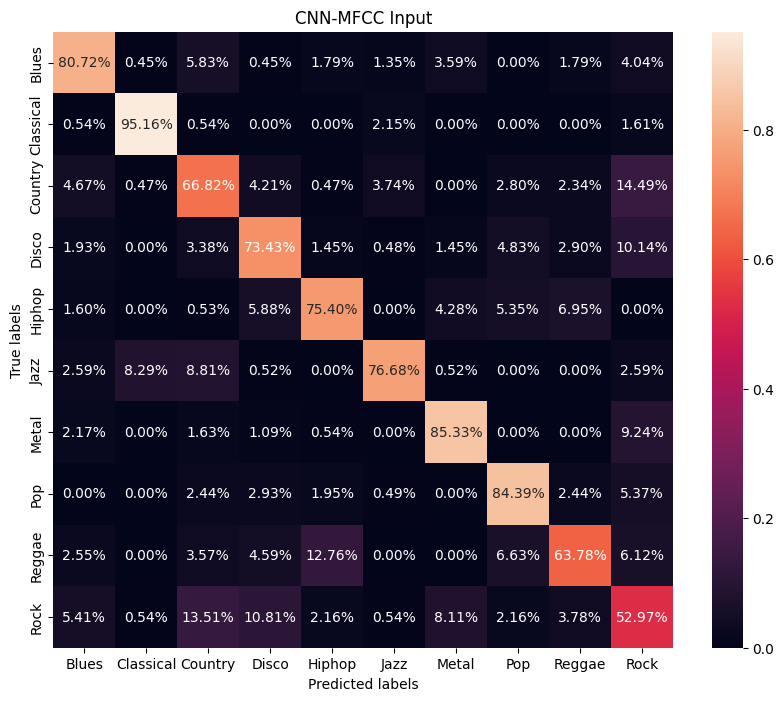

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC Input')
plt.show()

CNN experiments

In [ ]:
def build_model(input_shape):
    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 6, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 1, 32)         4128      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 1, 32)       

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 3.9845 - accuracy: 0.1878
Epoch 2/100
248/248 [==============================] - 1s 3ms/step - loss: 1.9685 - accuracy: 0.2884
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 1.8356 - accuracy: 0.3307
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 1.7465 - accuracy: 0.3727
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 1.6874 - accuracy: 0.3863
Epoch 6/100
248/248 [==============================] - 1s 3ms/step - loss: 1.6168 - accuracy: 0.4093
Epoch 7/100
248/248 [==============================] - 1s 3ms/step - loss: 1.5475 - accuracy: 0.4351
Epoch 8/100
248/248 [==============================] - 1s 3ms/step - loss: 1.5077 - accuracy: 0.4466
Epoch 9/100
248/248 [==============================] - 1s 4ms/step - loss: 1.4837 - accuracy: 0.4562
Epoch 10/100
248/248 [==============================] - 1s 4ms/step - loss: 1.4270 - accura

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 0.9679 - accuracy: 0.7162 - 242ms/epoch - 4ms/step

Test accuracy: 0.7161616086959839


62/62 [==============================] - 0s 2ms/step


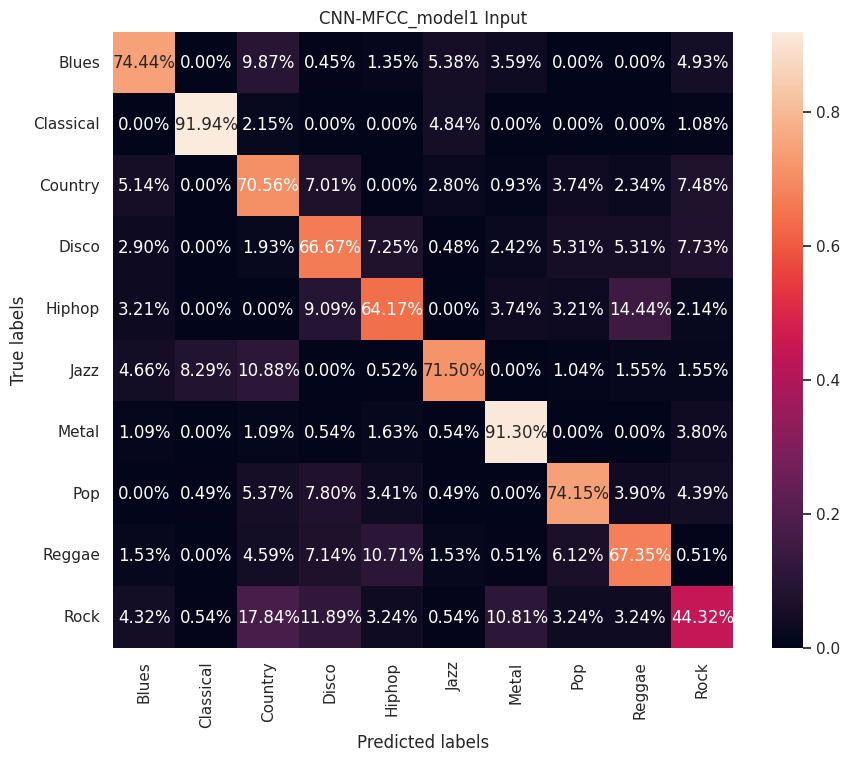

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC_model1 Input')
plt.show()

In [ ]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 3rd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 64, 6, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 62, 4, 64)         36928     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 31, 2, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 30, 1, 64)         16448     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 15, 1, 64)       

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 3s 4ms/step - loss: 2.2954 - accuracy: 0.2523
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 1.7862 - accuracy: 0.3598
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 1.6457 - accuracy: 0.4069
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 1.5616 - accuracy: 0.4356
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 1.4825 - accuracy: 0.4626
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 1.4148 - accuracy: 0.4846
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 1.3641 - accuracy: 0.5102
Epoch 8/100
248/248 [==============================] - 1s 4ms/step - loss: 1.3223 - accuracy: 0.5219
Epoch 9/100
248/248 [==============================] - 1s 4ms/step - loss: 1.2473 - accuracy: 0.5450
Epoch 10/100
248/248 [==============================] - 1s 4ms/step - loss: 1.2124 - accura

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 0.9738 - accuracy: 0.7606 - 329ms/epoch - 5ms/step

Test accuracy: 0.760606050491333


62/62 [==============================] - 0s 2ms/step


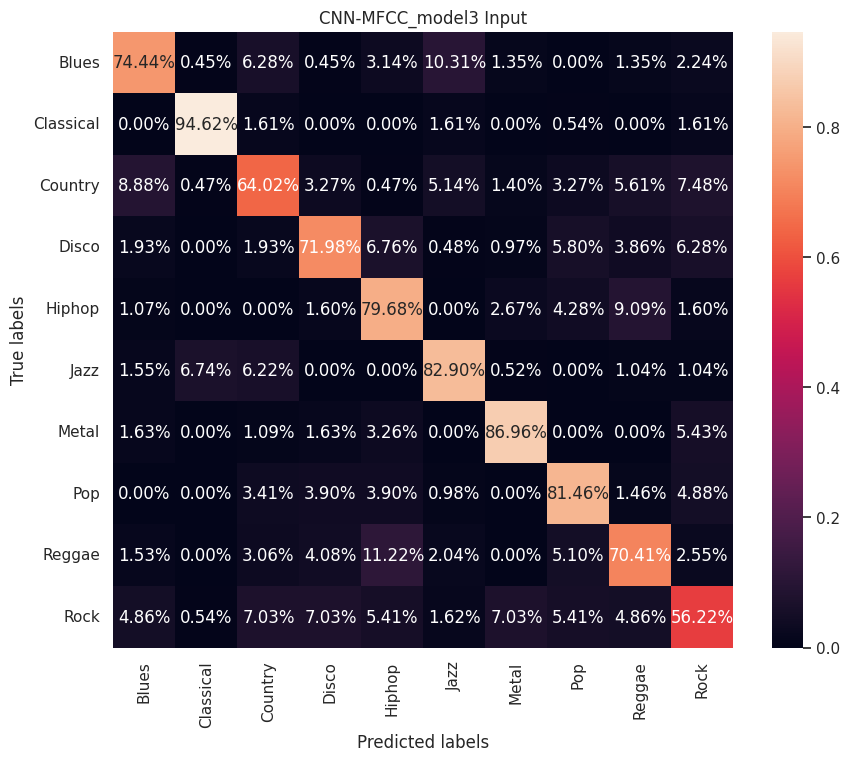

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC_model3 Input')
plt.show()

In [ ]:
def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 11, 128)      1280      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 64, 6, 128)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 64, 6, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 62, 4, 128)        147584    
                                                                 
 dropout_35 (Dropout)        (None, 62, 4, 128)        0         
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 31, 2, 128)      

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 5s 8ms/step - loss: 1.9527 - accuracy: 0.3557
Epoch 2/100
248/248 [==============================] - 2s 7ms/step - loss: 1.4860 - accuracy: 0.4875
Epoch 3/100
248/248 [==============================] - 2s 7ms/step - loss: 1.3167 - accuracy: 0.5350
Epoch 4/100
248/248 [==============================] - 2s 7ms/step - loss: 1.1911 - accuracy: 0.5856
Epoch 5/100
248/248 [==============================] - 2s 7ms/step - loss: 1.0759 - accuracy: 0.6262
Epoch 6/100
248/248 [==============================] - 2s 7ms/step - loss: 1.0043 - accuracy: 0.6457
Epoch 7/100
248/248 [==============================] - 2s 7ms/step - loss: 0.9532 - accuracy: 0.6623
Epoch 8/100
248/248 [==============================] - 2s 7ms/step - loss: 0.8827 - accuracy: 0.6916
Epoch 9/100
248/248 [==============================] - 2s 7ms/step - loss: 0.8262 - accuracy: 0.7076
Epoch 10/100
248/248 [==============================] - 2s 7ms/step - loss: 0.7857 - accura

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 1.0254 - accuracy: 0.7157 - 350ms/epoch - 6ms/step

Test accuracy: 0.715656578540802


62/62 [==============================] - 0s 2ms/step


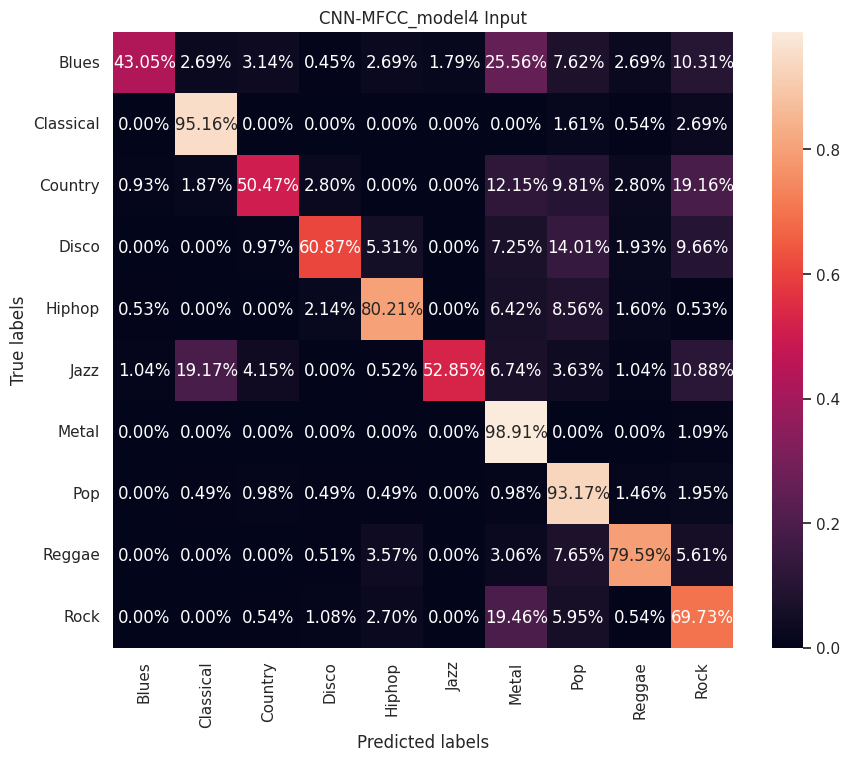

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC_model4 Input')
plt.show()

In [ ]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 128, 11, 128)      1280      
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 64, 6, 128)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_9 (Bat  (None, 64, 6, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 62, 4, 128)        147584    
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 31, 2, 128)        0         
 ng2D)                                                           
                                                     

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 3s 6ms/step - loss: 1.9373 - accuracy: 0.3783
Epoch 2/100
248/248 [==============================] - 1s 6ms/step - loss: 1.3707 - accuracy: 0.5303
Epoch 3/100
248/248 [==============================] - 1s 6ms/step - loss: 1.1427 - accuracy: 0.6030
Epoch 4/100
248/248 [==============================] - 1s 6ms/step - loss: 0.9990 - accuracy: 0.6563
Epoch 5/100
248/248 [==============================] - 1s 6ms/step - loss: 0.8955 - accuracy: 0.6956
Epoch 6/100
248/248 [==============================] - 1s 6ms/step - loss: 0.7955 - accuracy: 0.7263
Epoch 7/100
248/248 [==============================] - 1s 6ms/step - loss: 0.7215 - accuracy: 0.7524
Epoch 8/100
248/248 [==============================] - 1s 6ms/step - loss: 0.6548 - accuracy: 0.7783
Epoch 9/100
248/248 [==============================] - 1s 6ms/step - loss: 0.6111 - accuracy: 0.7887
Epoch 10/100
248/248 [==============================] - 1s 6ms/step - loss: 0.5387 - accura

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 0.9502 - accuracy: 0.7949 - 319ms/epoch - 5ms/step

Test accuracy: 0.794949471950531


62/62 [==============================] - 0s 2ms/step


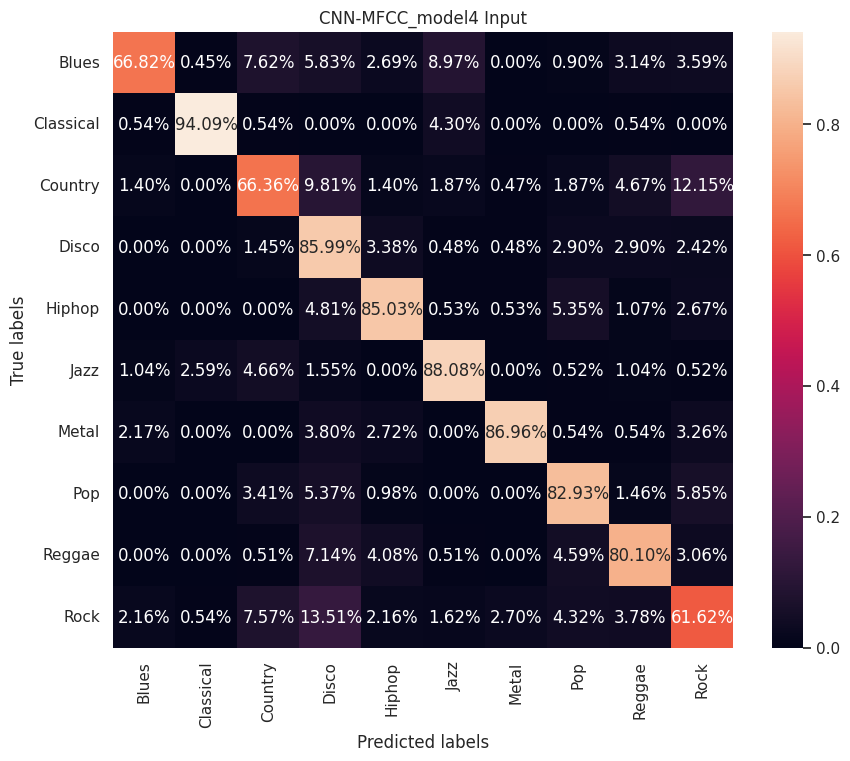

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels if needed
# If y_test is already in one-hot encoded format, you can skip this step
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC_model4 Input')
plt.show()

In [ ]:
def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# get train and test splits
X_train, X_test, y_train, y_test = prepare_datasets(0.2)

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 6, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 128)        147584    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 2, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 1, 128)        65664     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 1, 128)       

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 12s 6ms/step - loss: 1.7461 - accuracy: 0.3893
Epoch 2/100
248/248 [==============================] - 1s 5ms/step - loss: 1.3689 - accuracy: 0.4989
Epoch 3/100
248/248 [==============================] - 1s 5ms/step - loss: 1.2169 - accuracy: 0.5568
Epoch 4/100
248/248 [==============================] - 1s 5ms/step - loss: 1.0889 - accuracy: 0.6046
Epoch 5/100
248/248 [==============================] - 1s 5ms/step - loss: 1.0003 - accuracy: 0.6414
Epoch 6/100
248/248 [==============================] - 1s 5ms/step - loss: 0.9153 - accuracy: 0.6809
Epoch 7/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8384 - accuracy: 0.7069
Epoch 8/100
248/248 [==============================] - 1s 5ms/step - loss: 0.8020 - accuracy: 0.7209
Epoch 9/100
248/248 [==============================] - 1s 5ms/step - loss: 0.7118 - accuracy: 0.7569
Epoch 10/100
248/248 [==============================] - 1s 5ms/step - loss: 0.6745 - accur

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 1.3712 - accuracy: 0.7596 - 365ms/epoch - 6ms/step

Test accuracy: 0.7595959305763245


62/62 [==============================] - 0s 3ms/step


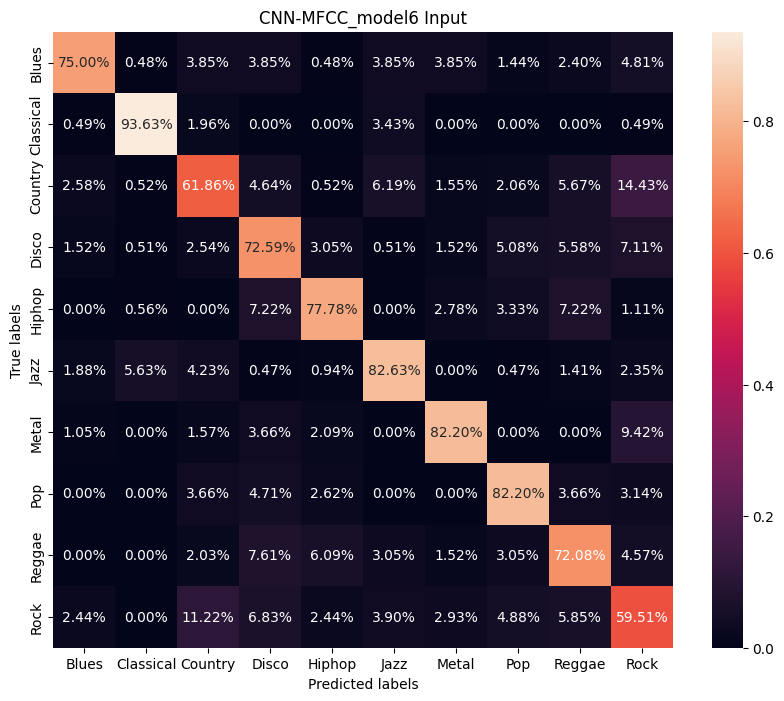

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels if needed
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the label names
label_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with label names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(label_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN-MFCC_model6 Input')
plt.show()

#RNN

In [ ]:
def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
# get train and test splits
X_train, X_test, y_train, y_test = prepare_datasets(0.2)  # 80% training, 20% test

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


ValueError: ignored

In [ ]:
# Reshape input data for LSTM
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))



# build model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])  # Adjust input shape
model = build_model(input_shape)


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 3s 10ms/step - loss: 0.2957 - accuracy: 0.9061
Epoch 2/100
248/248 [==============================] - 2s 9ms/step - loss: 0.2005 - accuracy: 0.9372
Epoch 3/100
248/248 [==============================] - 2s 9ms/step - loss: 0.2741 - accuracy: 0.9245
Epoch 4/100
248/248 [==============================] - 2s 9ms/step - loss: 0.2725 - accuracy: 0.9180
Epoch 5/100
248/248 [==============================] - 2s 9ms/step - loss: 0.1755 - accuracy: 0.9491
Epoch 6/100
248/248 [==============================] - 2s 10ms/step - loss: 0.1570 - accuracy: 0.9533
Epoch 7/100
248/248 [==============================] - 2s 10ms/step - loss: 0.1526 - accuracy: 0.9567
Epoch 8/100
248/248 [==============================] - 2s 9ms/step - loss: 0.1488 - accuracy: 0.9554
Epoch 9/100
248/248 [==============================] - 2s 9ms/step - loss: 0.1601 - accuracy: 0.9533
Epoch 10/100
248/248 [==============================] - 2s 9ms/step - loss: 0.1973 - acc

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 0s - loss: 1.7116 - accuracy: 0.7061 - 427ms/epoch - 7ms/step

Test accuracy: 0.7060605883598328


62/62 [==============================] - 0s 6ms/step


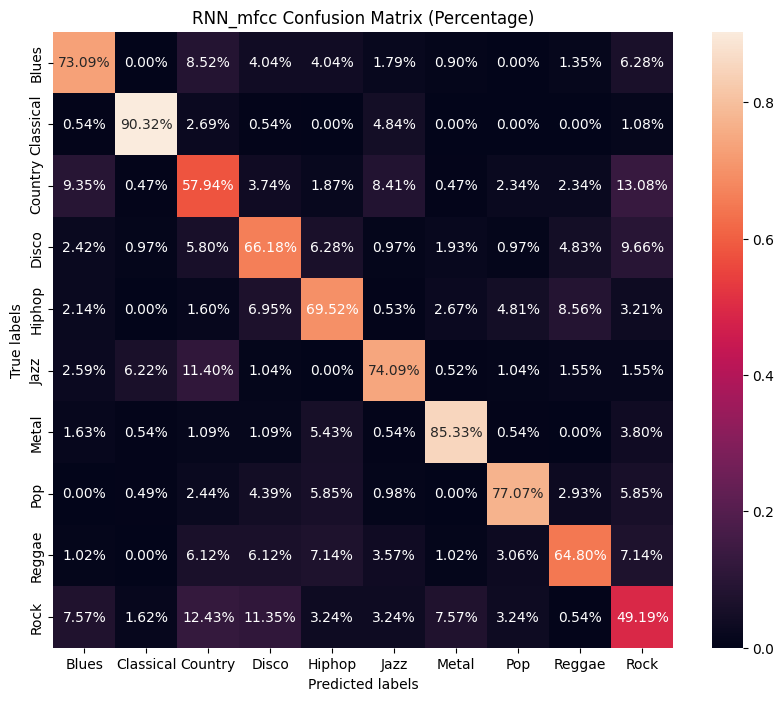

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels if needed
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the genre names
genre_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with genre names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(genre_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RNN_mfcc Confusion Matrix (Percentage)')
plt.show()


fixing overfitting

In [ ]:
#model 2
def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(32, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(32))

    # dense layer
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = build_model(input_shape)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 130, 32)           5888      
                                                                 
 lstm_9 (LSTM)               (None, 32)                8320      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                                 
Total params: 15594 (60.91 KB)
Trainable params: 15594 (60.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 6s 11ms/step - loss: 2.2594 - accuracy: 0.1637
Epoch 2/100
248/248 [==============================] - 2s 9ms/step - loss: 2.1458 - accuracy: 0.2458
Epoch 3/100
248/248 [==============================] - 2s 9ms/step - loss: 2.0215 - accuracy: 0.3146
Epoch 4/100
248/248 [==============================] - 2s 10ms/step - loss: 1.8944 - accuracy: 0.3495
Epoch 5/100
248/248 [==============================] - 2s 9ms/step - loss: 1.7973 - accuracy: 0.3790
Epoch 6/100
248/248 [==============================] - 2s 10ms/step - loss: 1.7363 - accuracy: 0.4008
Epoch 7/100
248/248 [==============================] - 3s 10ms/step - loss: 1.6862 - accuracy: 0.4121
Epoch 8/100
248/248 [==============================] - 2s 9ms/step - loss: 1.6467 - accuracy: 0.4218
Epoch 9/100
248/248 [==============================] - 2s 9ms/step - loss: 1.6138 - accuracy: 0.4320
Epoch 10/100
248/248 [==============================] - 2s 9ms/step - loss: 1.5979 - ac

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 1s - loss: 1.1771 - accuracy: 0.5859 - 1s/epoch - 16ms/step

Test accuracy: 0.5858585834503174


62/62 [==============================] - 1s 6ms/step


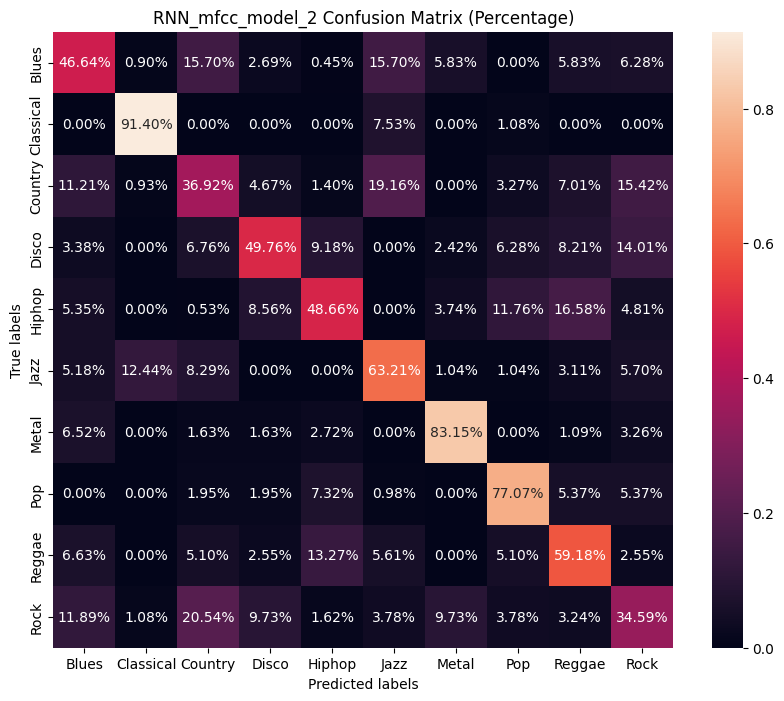

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels if needed
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the genre names
genre_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with genre names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(genre_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RNN_mfcc_model_2 Confusion Matrix (Percentage)')
plt.show()


In [ ]:
#model 3

def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128))

    # dense layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = build_model(input_shape)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 130, 128)          72704     
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 10)                1290      
                                                                 
Total params: 222090 (867.54 KB)
Trainable params: 222090 (867.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 6s 11ms/step - loss: 1.9688 - accuracy: 0.3140
Epoch 2/100
248/248 [==============================] - 3s 11ms/step - loss: 1.4941 - accuracy: 0.4725
Epoch 3/100
248/248 [==============================] - 3s 10ms/step - loss: 1.3203 - accuracy: 0.5359
Epoch 4/100
248/248 [==============================] - 3s 10ms/step - loss: 1.2010 - accuracy: 0.5855
Epoch 5/100
248/248 [==============================] - 3s 10ms/step - loss: 1.1124 - accuracy: 0.6210
Epoch 6/100
248/248 [==============================] - 3s 10ms/step - loss: 1.0342 - accuracy: 0.6493
Epoch 7/100
248/248 [==============================] - 3s 11ms/step - loss: 0.9746 - accuracy: 0.6707
Epoch 8/100
248/248 [==============================] - 3s 10ms/step - loss: 0.9250 - accuracy: 0.6873
Epoch 9/100
248/248 [==============================] - 3s 10ms/step - loss: 0.8578 - accuracy: 0.7113
Epoch 10/100
248/248 [==============================] - 3s 10ms/step - loss: 0.818

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 1s - loss: 1.0359 - accuracy: 0.7924 - 1s/epoch - 18ms/step

Test accuracy: 0.7924242615699768


62/62 [==============================] - 1s 7ms/step


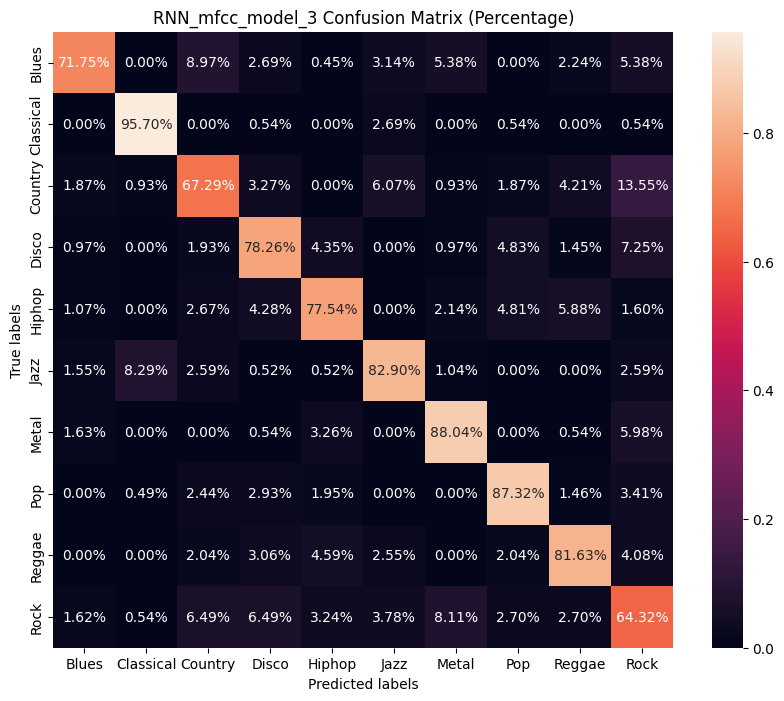

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the genre names
genre_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with genre names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(genre_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RNN_mfcc_model_3 Confusion Matrix (Percentage)')
plt.show()


In [ ]:
#model 4

def build_model(input_shape):


    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dropout(0.2))

    # dense layer
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model = build_model(input_shape)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 130, 128)          72704     
                                                                 
 dropout_8 (Dropout)         (None, 130, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 10)               

In [ ]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
248/248 [==============================] - 6s 11ms/step - loss: 1.9868 - accuracy: 0.3050
Epoch 2/100
248/248 [==============================] - 3s 11ms/step - loss: 1.5551 - accuracy: 0.4531
Epoch 3/100
248/248 [==============================] - 3s 11ms/step - loss: 1.3769 - accuracy: 0.5135
Epoch 4/100
248/248 [==============================] - 3s 11ms/step - loss: 1.2595 - accuracy: 0.5526
Epoch 5/100
248/248 [==============================] - 3s 11ms/step - loss: 1.1865 - accuracy: 0.5869
Epoch 6/100
248/248 [==============================] - 3s 11ms/step - loss: 1.1046 - accuracy: 0.6225
Epoch 7/100
248/248 [==============================] - 3s 11ms/step - loss: 1.0488 - accuracy: 0.6361
Epoch 8/100
248/248 [==============================] - 3s 11ms/step - loss: 0.9859 - accuracy: 0.6555
Epoch 9/100
248/248 [==============================] - 3s 11ms/step - loss: 0.9488 - accuracy: 0.6761
Epoch 10/100
248/248 [==============================] - 3s 11ms/step - loss: 0.879

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

62/62 - 1s - loss: 1.0765 - accuracy: 0.8020 - 1s/epoch - 17ms/step

Test accuracy: 0.8020201921463013


62/62 [==============================] - 0s 7ms/step


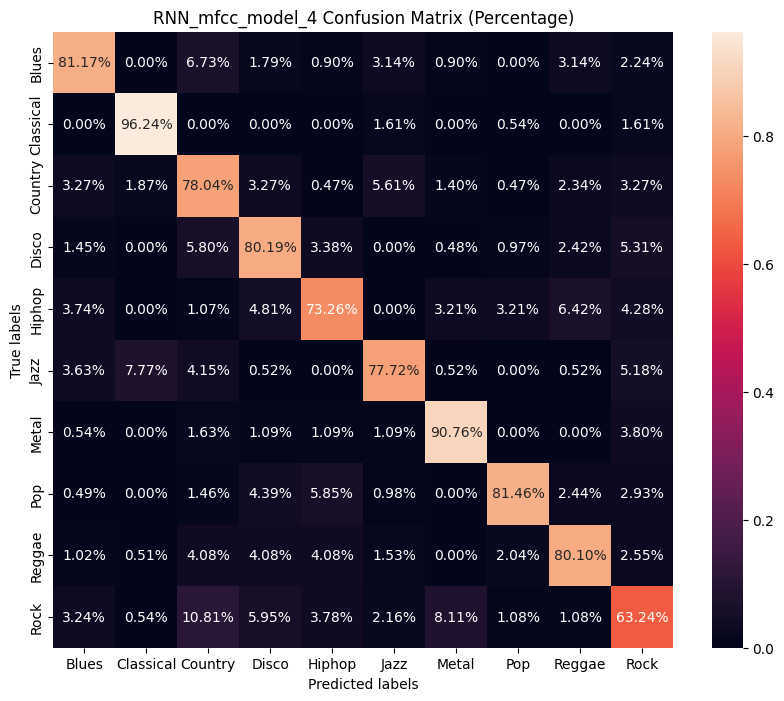

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics



# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

# Get the genre names
genre_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Create confusion matrix with genre names
confusion_mtx = confusion_matrix(y_true, y_pred_classes, labels=np.arange(len(genre_names)))

# Calculate percentages
confusion_mtx_percentage = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Visualize confusion matrix as a heatmap with percentages
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_percentage, annot=True, fmt='.2%', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('RNN_mfcc_model_4 Confusion Matrix (Percentage)')
plt.show()


## MLP

In [ ]:
inputs, targets = load_data(DATA_PATH)

In [ ]:
#split data into train and test
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)

In [ ]:
#build model
model = keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

        #1st hidden layer
        keras.layers.Dense(512, activation="relu"),
        #2nd hidden layer
        keras.layers.Dense(256, activation="relu"),
        #3rd hidden layer
        keras.layers.Dense(64, activation="relu"),
        #output layer
        keras.layers.Dense(10, activation="softmax")

])

In [ ]:
#optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
model = build_model(input_shape)

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 130, 128)          72704     
                                                                 
 dropout_14 (Dropout)        (None, 130, 128)          0         
                                                                 
 lstm_15 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 10)              

In [ ]:
model.fit(inputs_train, targets_train,
         validation_data=(inputs_test, targets_test),
         epochs=100,
         batch_size=32)

Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 23.4560 - accuracy: 0.1616 - val_loss: 3.4960 - val_accuracy: 0.2318
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 6.0628 - accuracy: 0.1582 - val_loss: 3.4645 - val_accuracy: 0.1571
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 4.2733 - accuracy: 0.1445 - val_loss: 3.4826 - val_accuracy: 0.1283
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 3.8128 - accuracy: 0.1444 - val_loss: 3.4677 - val_accuracy: 0.1328
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 3.6648 - accuracy: 0.1489 - val_loss: 3.4560 - val_accuracy: 0.1343
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 3.5624 - accuracy: 0.1470 - val_loss: 3.4479 - val_accuracy: 0.1354
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 3.4990 - accuracy: 0.1530 - val_loss: 3.4115 - val_accuracy: 0.149

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print out the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


62/62 [==============================] - 0s 2ms/step - loss: 1.5494 - accuracy: 0.5934
Test Accuracy: 59.34%


##MLP experiments

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

# split data into train and test
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)

# build model
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),
    # 1st hidden layer
    keras.layers.Dense(512, activation="relu"),
    # 2nd hidden layer
    keras.layers.Dense(256, activation="relu"),
    # 3rd hidden layer
    keras.layers.Dense(64, activation="relu"),
    # output layer
    keras.layers.Dense(10, activation="softmax")
])

# optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1690)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               865792    
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 64)                16448     
                                                                 
 dense_27 (Dense)            (None, 10)                650       
                                                                 
Total params: 1014218 (3.87 MB)
Trainable params: 1014218 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model.fit(inputs_train, targets_train, epochs=100, validation_data=(inputs_test, targets_test))


Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 5.6453 - accuracy: 0.2539 - val_loss: 2.2087 - val_accuracy: 0.1990
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 2.0295 - accuracy: 0.3047 - val_loss: 2.0257 - val_accuracy: 0.3061
Epoch 3/100
248/248 [==============================] - 1s 3ms/step - loss: 1.8655 - accuracy: 0.3615 - val_loss: 2.0721 - val_accuracy: 0.3288
Epoch 4/100
248/248 [==============================] - 1s 3ms/step - loss: 1.7680 - accuracy: 0.3814 - val_loss: 1.9477 - val_accuracy: 0.3434
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 1.6994 - accuracy: 0.3979 - val_loss: 2.0299 - val_accuracy: 0.2990
Epoch 6/100
248/248 [==============================] - 1s 3ms/step - loss: 1.6865 - accuracy: 0.4120 - val_loss: 1.9160 - val_accuracy: 0.3778
Epoch 7/100
248/248 [==============================] - 1s 3ms/step - loss: 1.5658 - accuracy: 0.4490 - val_loss: 1.9603 - val_accuracy: 0.3879

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


62/62 [==============================] - 0s 2ms/step - loss: 3.2292 - accuracy: 0.6384
Test Accuracy: 63.84%


62/62 [==============================] - 0s 2ms/step


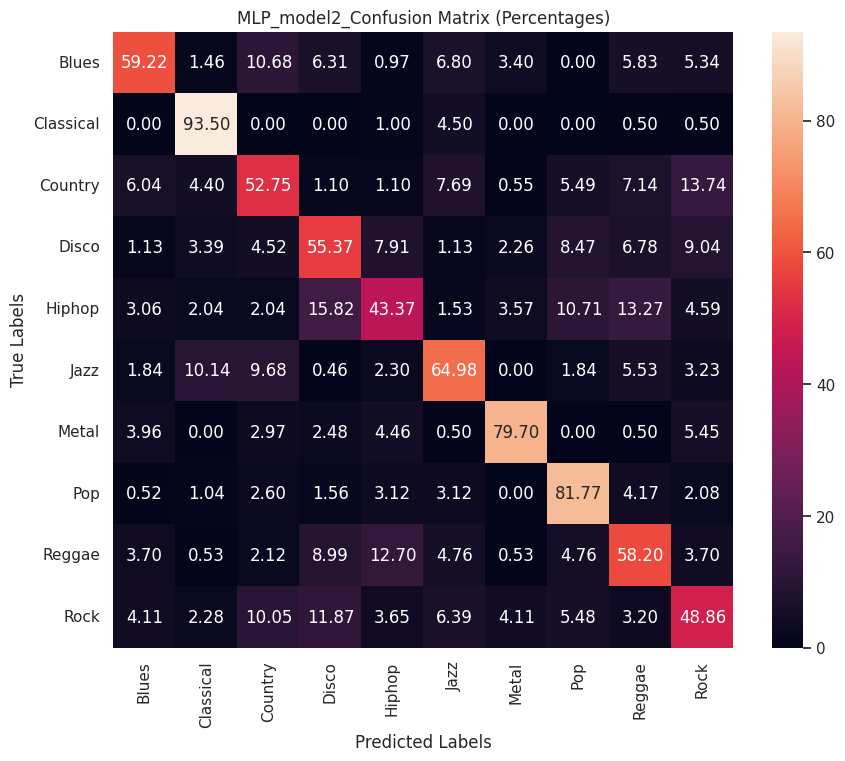

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

genre_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

# Get the model predictions on the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(targets_test, predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the heatmap with percentages
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', xticklabels=genre_names, yticklabels=genre_names)

plt.title('MLP_model2_Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
#model 3


#build model
model = keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

        #1st hidden layer
        keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #2nd hidden layer
        keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #3rd hidden layer
        keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #output layer
        keras.layers.Dense(10, activation="softmax")

])
# optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 1690)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               865792    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                16448     
                                                                 
 dropout_19 (Dropout)        (None, 64)              

In [ ]:
# Train the model
model.fit(inputs_train, targets_train, epochs=100, validation_data=(inputs_test, targets_test))


Epoch 1/100
248/248 [==============================] - 2s 4ms/step - loss: 17.6795 - accuracy: 0.1488 - val_loss: 3.4848 - val_accuracy: 0.1288
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 4.9733 - accuracy: 0.1316 - val_loss: 3.5032 - val_accuracy: 0.1197
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 4.0640 - accuracy: 0.1218 - val_loss: 3.4990 - val_accuracy: 0.1212
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 3.7537 - accuracy: 0.1270 - val_loss: 3.4901 - val_accuracy: 0.1253
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 3.6468 - accuracy: 0.1270 - val_loss: 3.4765 - val_accuracy: 0.1318
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 3.5681 - accuracy: 0.1315 - val_loss: 3.4534 - val_accuracy: 0.1409
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 3.5431 - accuracy: 0.1374 - val_loss: 3.4089 - val_accuracy: 0.157

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


62/62 [==============================] - 0s 2ms/step - loss: 1.5259 - accuracy: 0.6207
Test Accuracy: 62.07%


62/62 [==============================] - 0s 2ms/step


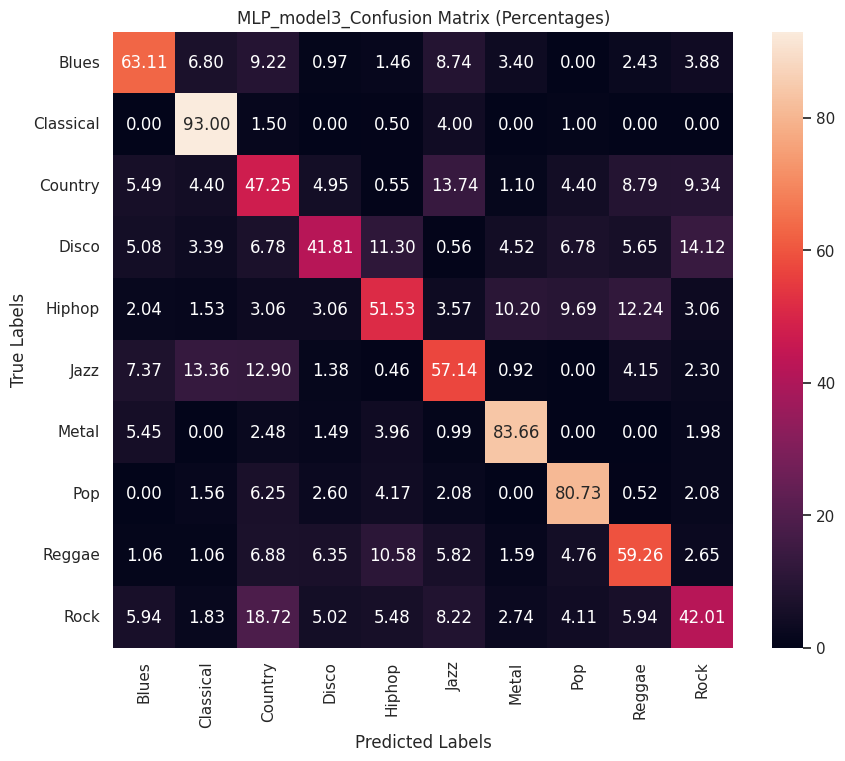

In [ ]:
# Get the model predictions on the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(targets_test, predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the heatmap with percentages
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', xticklabels=genre_names, yticklabels=genre_names)

plt.title('MLP_model3_Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#model 3


#build model
model = keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

        #1st hidden layer
        keras.layers.Dense(512, activation="relu"),
        #2nd hidden layer
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        #3rd hidden layer
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        #4th hidden layer
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        #5th hidden layer
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        #output layer
        keras.layers.Dense(10, activation="softmax")

])
# optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1690)              0         
                                                                 
 dense_32 (Dense)            (None, 512)               865792    
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                16448     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 32)              

In [ ]:
# Train the model
model.fit(inputs_train, targets_train, epochs=100, validation_data=(inputs_test, targets_test))


Epoch 1/100
248/248 [==============================] - 3s 5ms/step - loss: 6.6032 - accuracy: 0.1291 - val_loss: 2.2396 - val_accuracy: 0.1955
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 2.6365 - accuracy: 0.1531 - val_loss: 2.2097 - val_accuracy: 0.2136
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 2.3654 - accuracy: 0.1680 - val_loss: 2.2035 - val_accuracy: 0.1914
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 2.2979 - accuracy: 0.1809 - val_loss: 2.1683 - val_accuracy: 0.2333
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 2.2509 - accuracy: 0.1885 - val_loss: 2.1242 - val_accuracy: 0.2530
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 2.2253 - accuracy: 0.2054 - val_loss: 2.1155 - val_accuracy: 0.2556
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 2.1901 - accuracy: 0.2120 - val_loss: 2.1090 - val_accuracy: 0.2439

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


62/62 [==============================] - 0s 2ms/step - loss: 1.9353 - accuracy: 0.5621
Test Accuracy: 56.21%


62/62 [==============================] - 0s 2ms/step


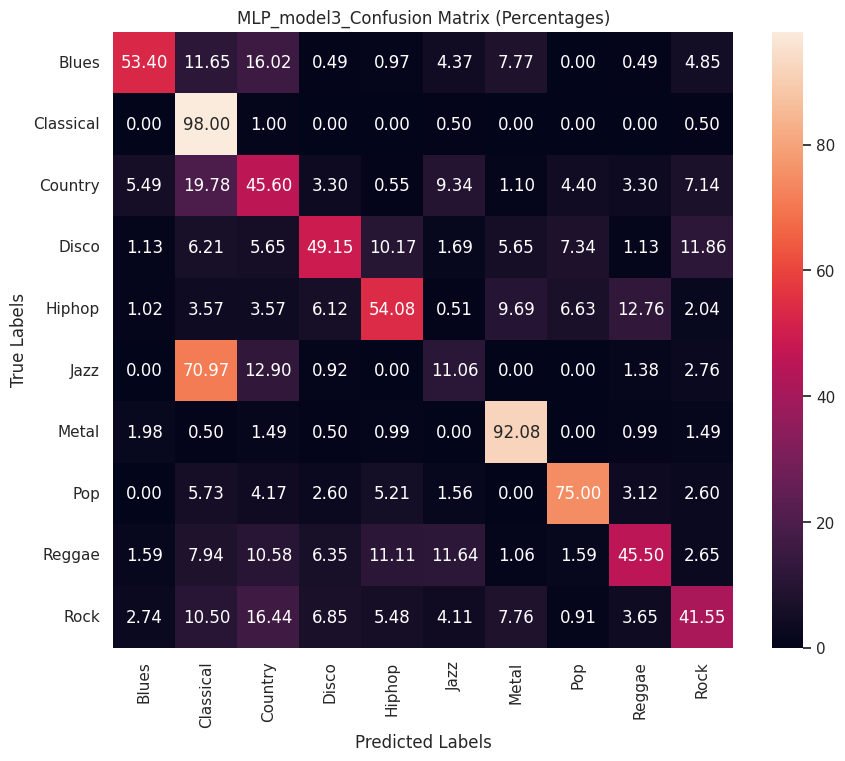

In [ ]:
# Get the model predictions on the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(targets_test, predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the heatmap with percentages
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', xticklabels=genre_names, yticklabels=genre_names)

plt.title('MLP_model3_Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#build model
model = keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

        #1st hidden layer
        keras.layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #2nd hidden layer
        keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #3rd hidden layer
        keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #4th hidden layer
        keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        #output layer
        keras.layers.Dense(10, activation="softmax")

])
# optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1690)              0         
                                                                 
 dense_38 (Dense)            (None, 1024)              1731584   
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 dense_39 (Dense)            (None, 512)               524800    
                                                                 
 dropout_25 (Dropout)        (None, 512)               0         
                                                                 
 dense_40 (Dense)            (None, 256)               131328    
                                                                 
 dropout_26 (Dropout)        (None, 256)             

In [ ]:
# Train the model
model.fit(inputs_train, targets_train, epochs=100, validation_data=(inputs_test, targets_test))


Epoch 1/100
248/248 [==============================] - 3s 5ms/step - loss: 17.2235 - accuracy: 0.1445 - val_loss: 4.4459 - val_accuracy: 0.2333
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 6.1571 - accuracy: 0.1656 - val_loss: 4.5506 - val_accuracy: 0.1662
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 5.0874 - accuracy: 0.1758 - val_loss: 4.4818 - val_accuracy: 0.1929
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 4.7933 - accuracy: 0.1837 - val_loss: 4.3969 - val_accuracy: 0.2146
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 4.6359 - accuracy: 0.1925 - val_loss: 4.3267 - val_accuracy: 0.2338
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 4.5147 - accuracy: 0.2295 - val_loss: 4.2874 - val_accuracy: 0.3086
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 4.4412 - accuracy: 0.2447 - val_loss: 4.2210 - val_accuracy: 0.339

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


62/62 [==============================] - 0s 2ms/step - loss: 1.7630 - accuracy: 0.6566
Test Accuracy: 65.66%


62/62 [==============================] - 0s 2ms/step


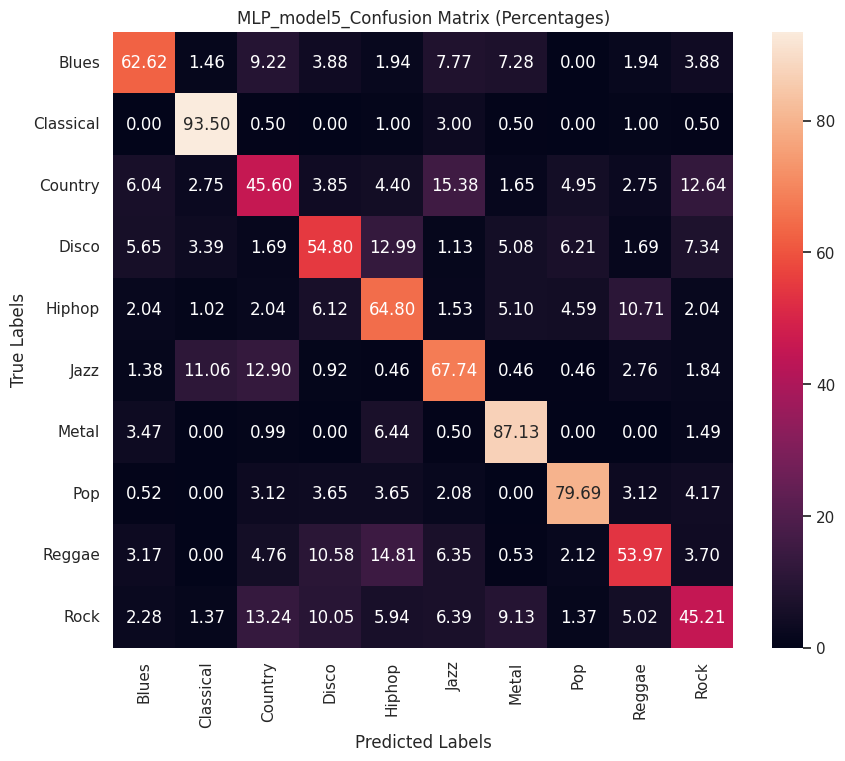

In [ ]:
# Get the model predictions on the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(targets_test, predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the heatmap with percentages
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', xticklabels=genre_names, yticklabels=genre_names)

plt.title('MLP_model5_Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
#build model
model = keras.Sequential([
        #input layer
        keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

        #1st hidden layer
        keras.layers.Dense(1024, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(0.4),
        #2nd hidden layer
        keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(0.4),
        #3rd hidden layer
        keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(0.4),
        #4th hidden layer
        keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(0.4),
        #output layer
        keras.layers.Dense(10, activation="softmax")

])
# optimize the neural network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 1690)              0         
                                                                 
 dense_43 (Dense)            (None, 1024)              1731584   
                                                                 
 dropout_28 (Dropout)        (None, 1024)              0         
                                                                 
 dense_44 (Dense)            (None, 512)               524800    
                                                                 
 dropout_29 (Dropout)        (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 256)               131328    
                                                                 
 dropout_30 (Dropout)        (None, 256)             

In [ ]:
# Train the model
model.fit(inputs_train, targets_train, epochs=100, validation_data=(inputs_test, targets_test))


Epoch 1/100
248/248 [==============================] - 3s 5ms/step - loss: 42.3828 - accuracy: 0.1233 - val_loss: 13.9836 - val_accuracy: 0.2505
Epoch 2/100
248/248 [==============================] - 1s 4ms/step - loss: 18.2799 - accuracy: 0.1353 - val_loss: 13.8654 - val_accuracy: 0.1949
Epoch 3/100
248/248 [==============================] - 1s 4ms/step - loss: 15.1792 - accuracy: 0.1420 - val_loss: 13.7581 - val_accuracy: 0.2076
Epoch 4/100
248/248 [==============================] - 1s 4ms/step - loss: 14.2619 - accuracy: 0.1446 - val_loss: 13.6033 - val_accuracy: 0.2106
Epoch 5/100
248/248 [==============================] - 1s 4ms/step - loss: 13.8683 - accuracy: 0.1577 - val_loss: 13.3938 - val_accuracy: 0.2535
Epoch 6/100
248/248 [==============================] - 1s 4ms/step - loss: 13.5315 - accuracy: 0.1743 - val_loss: 13.1774 - val_accuracy: 0.2848
Epoch 7/100
248/248 [==============================] - 1s 4ms/step - loss: 13.2640 - accuracy: 0.1995 - val_loss: 12.8986 - val_ac

In [ ]:


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(inputs_test, targets_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


62/62 [==============================] - 0s 2ms/step - loss: 1.5192 - accuracy: 0.6293
Test Accuracy: 62.93%


62/62 [==============================] - 0s 2ms/step


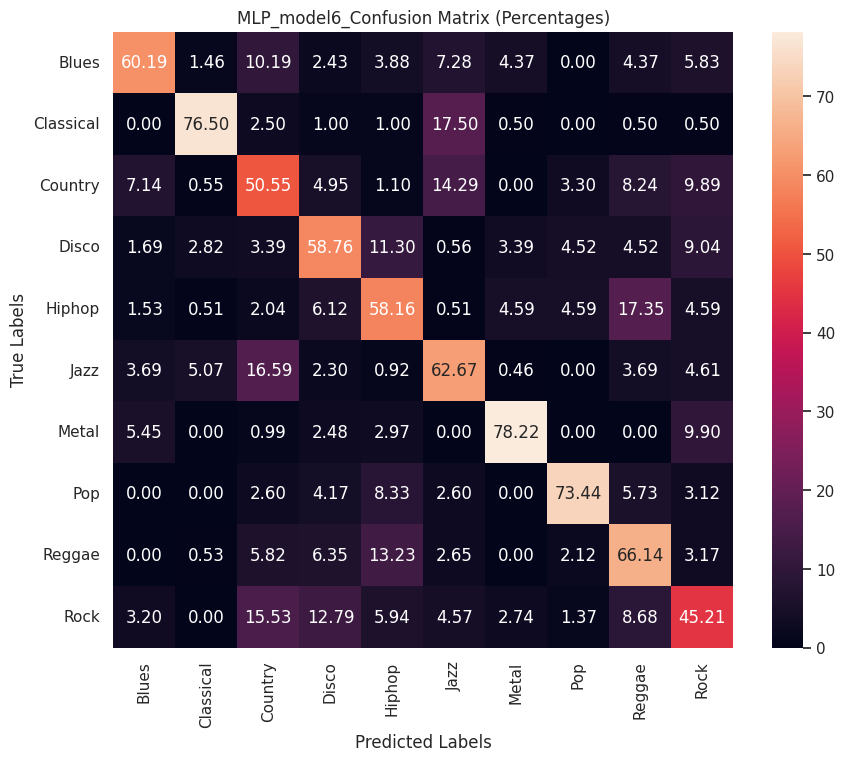

In [ ]:
# Get the model predictions on the test set
predictions = model.predict(inputs_test)
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(targets_test, predicted_labels)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot the heatmap with percentages
sns.set()
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', xticklabels=genre_names, yticklabels=genre_names)

plt.title('MLP_model6_Confusion Matrix (Percentages)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()